In [ ]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [ ]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
# other dependencies
#!pip install timm ipywidgets

In [ ]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

In [6]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [7]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [8]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob

In [9]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [10]:
#Global Training variables 
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 128
test_batch_size = 128
DEBUG = False
num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [11]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

In [12]:
def load_model(filepath, model):
    # Instantiate model to inspect
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

In [13]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
    
    
    return test_loss, test_acc , all_y,all_y_pred

In [14]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [15]:
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []
    best_val_loss = np.inf
    best_val_acc = -np.inf
    best_train_acc = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_acc.append(train_acc)
        val_loss, val_acc , _,_ = test_model(model, val_loader, criterion, classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val accuracy = " + str(val_acc))
        all_val_loss.append(val_loss)
        all_val_acc.append(val_acc)
        
        acc_metric = val_acc
        best_acc_metric = best_val_acc
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print("Now printing classification rport... ")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion, classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_acc = val_acc
            best_val_loss = val_loss
            overrun_counter = -1
        overrun_counter += 1
        print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [16]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [17]:
def concat_df(df_offset, indices):
    list_df_ind = []
    #print("len of indices = " + str(len(indices)))
    for ind in indices :
        df_name = "df_"+ str(ind)
        df_name = df_offset[df_offset['specie_ind'] == ind]
        list_df_ind.append(df_name)
    df_offset_trimmed = pd.concat(list_df_ind)
    return(df_offset_trimmed)

In [18]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### 3 The Data

### Read CSV and get train/test groups

In [19]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [20]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"

    

In [21]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [22]:
USE_SHORT_AUDIO = True

In [23]:
df_offset = get_offsets_df(df, short_audio=USE_SHORT_AUDIO)

In [24]:
df_offset

,id,offset,length,specie_ind
0,53,0,0.463456,2
1,57,0,0.170249,2
2,61,0,0.104041,2
3,69,0,0.274290,2
4,56,0,0.420894,2
...,...,...,...,...
151807,3561,71681,11.614280,8
151808,3561,74241,11.614280,8
151809,3552,0,2.920249,8
151810,3552,2561,2.920249,8


In [25]:
from sklearn.model_selection import train_test_split

df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [26]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [27]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [28]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [29]:
len(df_val_offset)

24290

In [30]:
#get_specie_distri(df_train_offset , classes , type_df = "train")
#get_specie_distri(df_val_offset , classes , type_df = "Val")
get_specie_distri(df_test_offset , classes , type_df = "Test")

DF type = Test
i = 0
9409
DF type = Test
i = 1
4484
DF type = Test
i = 2
722
DF type = Test
i = 3
4154
DF type = Test
i = 4
1140
DF type = Test
i = 5
600
DF type = Test
i = 6
823
DF type = Test
i = 7
407
DF type = Test
i = 8
8624


In [31]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [32]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_zero(x_temp,rate = config.rate, min_length = config.min_duration ):
    #print("inside padding zero...")
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    #print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [33]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [34]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [35]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,16705,1463,10241,5.545616,8
1,4093,633,2561,14.860309,8
2,2226,199938,99841,45.100000,8
3,90582,222040,28161,10.240000,0
4,30375,220741,0,5.120000,1


In [36]:
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_zero(waveform)
        else:
            f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [37]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                          fmin=400, fmax=2000, sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [38]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [39]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
from torch.utils.data.sampler import WeightedRandomSampler
class_sample_count = []
for i in range(0,len(classes)):
    df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
    print("i = " +str(i))
    print(len(df_temp))
    class_sample_count.append(len(df_temp))
print("class_sample_count = " + str(class_sample_count))
class_sample_count_arr = np.array(class_sample_count)
weight = 1. / class_sample_count_arr
print("weight = " +str(weight))
samples_weight = []
for t in range(len(classes)):
    samples_weight.append(weight[t])
    
samples_weight = np.array(samples_weight)
print("samples_weight = " +str(samples_weight))

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


i = 0
30103
i = 1
14049
i = 2
2324
i = 3
13305
i = 4
3624
i = 5
1922
i = 6
2821
i = 7
1259
i = 8
27752
class_sample_count = [30103, 14049, 2324, 13305, 3624, 1922, 2821, 1259, 27752]
weight = [3.32192805e-05 7.11794434e-05 4.30292599e-04 7.51597144e-05
 2.75938190e-04 5.20291363e-04 3.54484225e-04 7.94281176e-04
 3.60334390e-05]
samples_weight = [3.32192805e-05 7.11794434e-05 4.30292599e-04 7.51597144e-05
 2.75938190e-04 5.20291363e-04 3.54484225e-04 7.94281176e-04
 3.60334390e-05]


In [40]:
df_train_offset

,index,id,offset,length,specie_ind
0,16705,1463,10241,5.545616,8
1,4093,633,2561,14.860309,8
2,2226,199938,99841,45.100000,8
3,90582,222040,28161,10.240000,0
4,30375,220741,0,5.120000,1
...,...,...,...,...,...
97154,150466,3340,5121,8.648908,8
97155,57618,221319,286721,40.900000,3
97156,142150,208516,2561,2.560000,0
97157,86295,221907,133121,25.600000,3


In [41]:
train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,sampler = sampler,batch_size = batch_size
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [42]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 97159
Length of train loader = 704


In [43]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [44]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [45]:
len(df_train_offset)

97159

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0790 seconds
Training on cuda:0


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 0batch = 0 of 704duraation = 0.07267340024312337
epoch = 0batch = 200 of 704duraation = 4.177179066340129
epoch = 0batch = 400 of 704duraation = 8.240023422241212
epoch = 0batch = 600 of 704duraation = 12.331645715236665
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_14_04_54_10.pth
Now printing classification rport... 


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.36      0.00      0.00      9409
culex pipiens complex       0.27      0.03      0.05      4484
           ae aegypti       0.00      0.00      0.00       722
       an funestus ss       0.00      0.00      0.00      4154
         an squamosus       0.00      0.00      0.00      1140
          an coustani       0.02      0.02      0.02       600
         ma uniformis       0.00      0.00      0.00       823
         ma africanus       0.00      0.00      0.00       407
               others       0.27      0.91      0.42      8624

             accuracy                           0.26     30363
            macro avg       0.10      0.11      0.05     30363
         weighted avg       0.23      0.26      0.13     30363



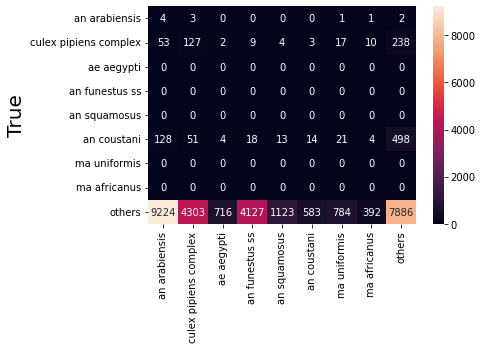

Epoch: 0, Train Loss: 0.21150604, Train Acc: 0.95378889, Val Loss: 0.02202323, Val Acc: 0.26331824, overrun_counter 0


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 1batch = 0 of 704duraation = 0.07270066340764364
epoch = 1batch = 200 of 704duraation = 4.209543661276499
epoch = 1batch = 400 of 704duraation = 8.283457732200622
epoch = 1batch = 600 of 704duraation = 12.383861434459686
Epoch: 1, Train Loss: 0.00207212, Train Acc: 1.00000000, Val Loss: 0.02532378, Val Acc: 0.26060107, overrun_counter 1


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 2batch = 0 of 704duraation = 0.07701890865961711
epoch = 2batch = 200 of 704duraation = 4.157389807701111
epoch = 2batch = 400 of 704duraation = 8.232253535588582
epoch = 2batch = 600 of 704duraation = 12.330902349948882
Epoch: 2, Train Loss: 0.00071649, Train Acc: 1.00000000, Val Loss: 0.02782753, Val Acc: 0.25911898, overrun_counter 2


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 3batch = 0 of 704duraation = 0.07853611707687377
epoch = 3batch = 200 of 704duraation = 4.131480141480764
epoch = 3batch = 400 of 704duraation = 8.215541076660156
epoch = 3batch = 600 of 704duraation = 12.312650096416473
Epoch: 3, Train Loss: 0.00033750, Train Acc: 1.00000000, Val Loss: 0.02976017, Val Acc: 0.25751338, overrun_counter 3


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 4batch = 0 of 704duraation = 0.07708176771799723
epoch = 4batch = 200 of 704duraation = 4.140695639451345
epoch = 4batch = 400 of 704duraation = 8.213486850261688
epoch = 4batch = 600 of 704duraation = 12.287878855069478
Epoch: 4, Train Loss: 0.02243829, Train Acc: 0.99626667, Val Loss: 0.02535492, Val Acc: 0.25043228, overrun_counter 4


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 5batch = 0 of 704duraation = 0.07055301666259765
epoch = 5batch = 200 of 704duraation = 4.145683936278025
epoch = 5batch = 400 of 704duraation = 8.21178940931956
epoch = 5batch = 600 of 704duraation = 12.31570001045863
Saving model to: ../outputs/models/pytorch/model_e5_2022_09_14_06_30_08.pth
Now printing classification rport... 


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.29      0.04      0.07      9409
culex pipiens complex       0.14      0.04      0.06      4484
           ae aegypti       0.00      0.00      0.00       722
       an funestus ss       0.00      0.00      0.00      4154
         an squamosus       0.00      0.00      0.00      1140
          an coustani       0.03      0.02      0.02       600
         ma uniformis       0.00      0.00      0.00       823
         ma africanus       0.00      0.00      0.00       407
               others       0.28      0.88      0.42      8624

             accuracy                           0.27     30363
            macro avg       0.08      0.11      0.06     30363
         weighted avg       0.19      0.27      0.15     30363



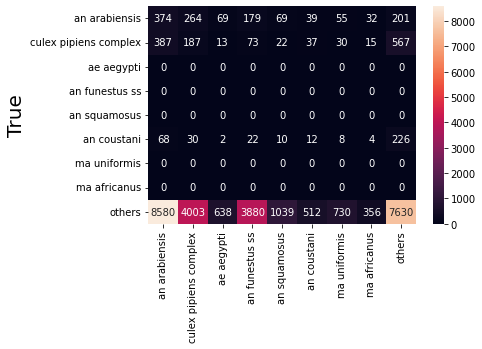

Epoch: 5, Train Loss: 0.00037411, Train Acc: 0.99995556, Val Loss: 0.02886746, Val Acc: 0.27056402, overrun_counter 0


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 6batch = 0 of 704duraation = 0.0740537683169047
epoch = 6batch = 200 of 704duraation = 4.200074005126953
epoch = 6batch = 400 of 704duraation = 8.270568931102753
epoch = 6batch = 600 of 704duraation = 12.352995336055756
Epoch: 6, Train Loss: 0.00014582, Train Acc: 0.99998889, Val Loss: 0.03051166, Val Acc: 0.26879374, overrun_counter 1


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 7batch = 0 of 704duraation = 0.0749692956606547
epoch = 7batch = 200 of 704duraation = 4.196443823973338
epoch = 7batch = 400 of 704duraation = 8.27894095579783
epoch = 7batch = 600 of 704duraation = 12.350976447264353
Saving model to: ../outputs/models/pytorch/model_e7_2022_09_14_07_11_30.pth
Now printing classification rport... 


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.21      0.01      0.02      9409
culex pipiens complex       0.15      0.01      0.02      4484
           ae aegypti       0.00      0.00      0.00       722
       an funestus ss       0.00      0.00      0.00      4154
         an squamosus       0.00      0.00      0.00      1140
          an coustani       0.02      0.01      0.01       600
         ma uniformis       0.00      0.00      0.00       823
         ma africanus       0.00      0.00      0.00       407
               others       0.28      0.95      0.43      8624

             accuracy                           0.27     30363
            macro avg       0.07      0.11      0.05     30363
         weighted avg       0.17      0.27      0.13     30363



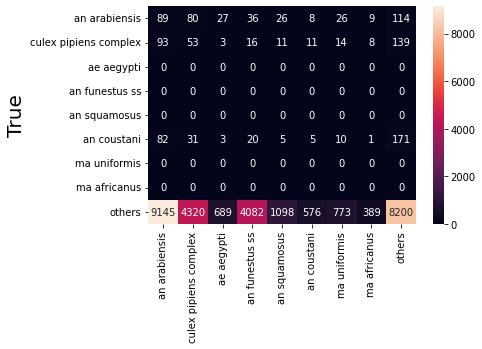

Epoch: 7, Train Loss: 0.00653534, Train Acc: 0.99751111, Val Loss: 0.02913187, Val Acc: 0.27443392, overrun_counter 0


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 8batch = 0 of 704duraation = 0.08141252994537354
epoch = 8batch = 200 of 704duraation = 4.174503429730733
epoch = 8batch = 400 of 704duraation = 8.257235395908356
epoch = 8batch = 600 of 704duraation = 12.392827320098878
Epoch: 8, Train Loss: 0.00221897, Train Acc: 0.99922222, Val Loss: 0.02795916, Val Acc: 0.25994236, overrun_counter 1


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 9batch = 0 of 704duraation = 0.07487101554870605
epoch = 9batch = 200 of 704duraation = 4.139745577176412
epoch = 9batch = 400 of 704duraation = 8.23042099873225
epoch = 9batch = 600 of 704duraation = 12.28812423547109
Epoch: 9, Train Loss: 0.00055123, Train Acc: 0.99988889, Val Loss: 0.02656902, Val Acc: 0.27443392, overrun_counter 2


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 10batch = 0 of 704duraation = 0.07935765186945597
epoch = 10batch = 200 of 704duraation = 4.159721354643504
epoch = 10batch = 400 of 704duraation = 8.232224527994791
epoch = 10batch = 600 of 704duraation = 12.326060489813488
Epoch: 10, Train Loss: 0.00004974, Train Acc: 1.00000000, Val Loss: 0.02894687, Val Acc: 0.27332235, overrun_counter 3


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 11batch = 0 of 704duraation = 0.0737147569656372
epoch = 11batch = 200 of 704duraation = 4.153946081797282
epoch = 11batch = 400 of 704duraation = 8.20224967400233
epoch = 11batch = 600 of 704duraation = 12.297077445189158
Epoch: 11, Train Loss: 0.00003304, Train Acc: 1.00000000, Val Loss: 0.02983027, Val Acc: 0.27266365, overrun_counter 4


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 12batch = 0 of 704duraation = 0.07879887421925863
epoch = 12batch = 200 of 704duraation = 4.151476685206095
epoch = 12batch = 400 of 704duraation = 8.26706003745397
epoch = 12batch = 600 of 704duraation = 12.32483730316162
Epoch: 12, Train Loss: 0.00002008, Train Acc: 1.00000000, Val Loss: 0.03154963, Val Acc: 0.27270482, overrun_counter 5


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 13batch = 0 of 704duraation = 0.07943553924560547
epoch = 13batch = 200 of 704duraation = 4.145573798815409
epoch = 13batch = 400 of 704duraation = 8.219343666235606
epoch = 13batch = 600 of 704duraation = 12.314518038431803
Saving model to: ../outputs/models/pytorch/model_e13_2022_09_14_09_05_44.pth
Now printing classification rport... 


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.27      0.02      0.03      9409
culex pipiens complex       0.09      0.00      0.00      4484
           ae aegypti       0.00      0.00      0.00       722
       an funestus ss       0.00      0.00      0.00      4154
         an squamosus       0.00      0.00      0.00      1140
          an coustani       0.02      0.01      0.02       600
         ma uniformis       0.00      0.00      0.00       823
         ma africanus       0.00      0.00      0.00       407
               others       0.28      0.96      0.44      8624

             accuracy                           0.28     30363
            macro avg       0.07      0.11      0.05     30363
         weighted avg       0.18      0.28      0.14     30363



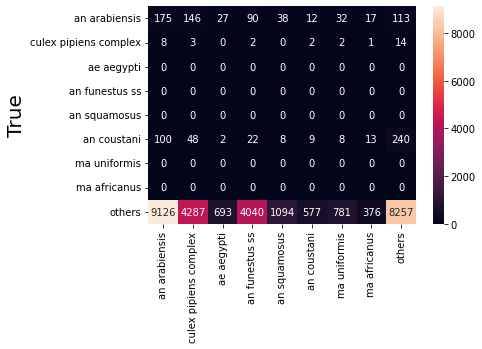

Epoch: 13, Train Loss: 0.00001746, Train Acc: 1.00000000, Val Loss: 0.03415156, Val Acc: 0.27953890, overrun_counter 0


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 14batch = 0 of 704duraation = 0.07564486265182495
epoch = 14batch = 200 of 704duraation = 4.171351130803426
epoch = 14batch = 400 of 704duraation = 8.227810641129812
epoch = 14batch = 600 of 704duraation = 12.350269675254822
Epoch: 14, Train Loss: 0.00001108, Train Acc: 1.00000000, Val Loss: 0.03521582, Val Acc: 0.27307534, overrun_counter 1


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 15batch = 0 of 704duraation = 0.08315274318059286
epoch = 15batch = 200 of 704duraation = 4.196511658032735
epoch = 15batch = 400 of 704duraation = 8.273106543223063
epoch = 15batch = 600 of 704duraation = 12.322965093453725
Epoch: 15, Train Loss: 0.00000803, Train Acc: 1.00000000, Val Loss: 0.03591559, Val Acc: 0.27410457, overrun_counter 2


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 16batch = 0 of 704duraation = 0.07409943342208862
epoch = 16batch = 200 of 704duraation = 4.162719372908274
epoch = 16batch = 400 of 704duraation = 8.231538716952006
epoch = 16batch = 600 of 704duraation = 12.334427281220753
Epoch: 16, Train Loss: 0.00000580, Train Acc: 1.00000000, Val Loss: 0.03671953, Val Acc: 0.27319885, overrun_counter 3


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 17batch = 0 of 704duraation = 0.0760043740272522
epoch = 17batch = 200 of 704duraation = 4.153355471293131
epoch = 17batch = 400 of 704duraation = 8.238092148303986
epoch = 17batch = 600 of 704duraation = 12.339606753985088
Epoch: 17, Train Loss: 0.00000436, Train Acc: 1.00000000, Val Loss: 0.03763575, Val Acc: 0.27336352, overrun_counter 4


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 18batch = 0 of 704duraation = 0.07876852750778199
epoch = 18batch = 200 of 704duraation = 4.171775917212169
epoch = 18batch = 400 of 704duraation = 8.225374313195546
epoch = 18batch = 600 of 704duraation = 12.304616868495941
Epoch: 18, Train Loss: 0.00000436, Train Acc: 1.00000000, Val Loss: 0.03396819, Val Acc: 0.27385755, overrun_counter 5


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 19batch = 0 of 704duraation = 0.07208897272745768
epoch = 19batch = 200 of 704duraation = 4.196616792678833
epoch = 19batch = 400 of 704duraation = 8.302340026696523
epoch = 19batch = 600 of 704duraation = 12.341542867819468
Epoch: 19, Train Loss: 0.01526598, Train Acc: 0.99834444, Val Loss: 0.03086202, Val Acc: 0.27142857, overrun_counter 6


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 20batch = 0 of 704duraation = 0.08172570069630941
epoch = 20batch = 200 of 704duraation = 4.163402740160624
epoch = 20batch = 400 of 704duraation = 8.239202908674876
epoch = 20batch = 600 of 704duraation = 12.315713040033977
Epoch: 20, Train Loss: 0.01184000, Train Acc: 0.99718889, Val Loss: 0.02284590, Val Acc: 0.25512557, overrun_counter 7


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 21batch = 0 of 704duraation = 0.08270018100738526
epoch = 21batch = 200 of 704duraation = 4.18013798793157
epoch = 21batch = 400 of 704duraation = 8.273362187544505
epoch = 21batch = 600 of 704duraation = 12.350824836889903
Saving model to: ../outputs/models/pytorch/model_e21_2022_09_14_11_36_36.pth
Now printing classification rport... 


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

        an arabiensis       0.23      0.10      0.14      9409
culex pipiens complex       0.17      0.01      0.01      4484
           ae aegypti       0.00      0.00      0.00       722
       an funestus ss       0.00      0.00      0.00      4154
         an squamosus       0.00      0.00      0.00      1140
          an coustani       0.03      0.03      0.03       600
         ma uniformis       0.00      0.00      0.00       823
         ma africanus       0.00      0.00      0.00       407
               others       0.30      0.88      0.44      8624

             accuracy                           0.28     30363
            macro avg       0.08      0.11      0.07     30363
         weighted avg       0.18      0.28      0.17     30363



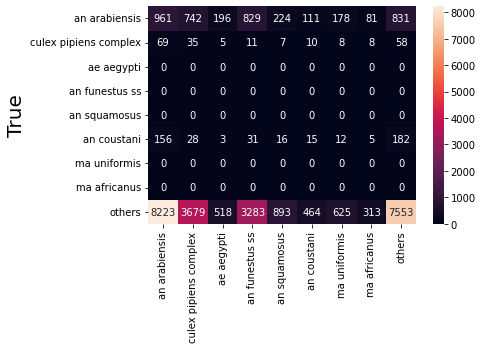

Epoch: 21, Train Loss: 0.00332174, Train Acc: 0.99886667, Val Loss: 0.02683818, Val Acc: 0.28077398, overrun_counter 0


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 22batch = 0 of 704duraation = 0.07301191091537476
epoch = 22batch = 200 of 704duraation = 4.18639022509257
epoch = 22batch = 400 of 704duraation = 8.2885218222936
epoch = 22batch = 600 of 704duraation = 12.314330144723256
Epoch: 22, Train Loss: 0.00006793, Train Acc: 1.00000000, Val Loss: 0.02916279, Val Acc: 0.28003294, overrun_counter 1


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 23batch = 0 of 704duraation = 0.07950719197591145
epoch = 23batch = 200 of 704duraation = 4.190227564175924
epoch = 23batch = 400 of 704duraation = 8.28075720469157
epoch = 23batch = 600 of 704duraation = 12.41136674483617
Epoch: 23, Train Loss: 0.00005913, Train Acc: 0.99998889, Val Loss: 0.03139317, Val Acc: 0.27056402, overrun_counter 2


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 24batch = 0 of 704duraation = 0.08484625418980916
epoch = 24batch = 200 of 704duraation = 4.1680292844772335
epoch = 24batch = 400 of 704duraation = 8.255335354804993
epoch = 24batch = 600 of 704duraation = 12.343585069974264
Epoch: 24, Train Loss: 0.00002573, Train Acc: 1.00000000, Val Loss: 0.03214797, Val Acc: 0.27019350, overrun_counter 3


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 25batch = 0 of 704duraation = 0.06640472014745076
epoch = 25batch = 200 of 704duraation = 4.174247030417124
epoch = 25batch = 400 of 704duraation = 8.283840135733287
epoch = 25batch = 600 of 704duraation = 12.38413111368815
Epoch: 25, Train Loss: 0.00001719, Train Acc: 1.00000000, Val Loss: 0.03275208, Val Acc: 0.27163442, overrun_counter 4


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 26batch = 0 of 704duraation = 0.07720054785410563
epoch = 26batch = 200 of 704duraation = 4.170886838436127
epoch = 26batch = 400 of 704duraation = 8.236335901419322
epoch = 26batch = 600 of 704duraation = 12.356719879309336
Epoch: 26, Train Loss: 0.00001267, Train Acc: 1.00000000, Val Loss: 0.03449587, Val Acc: 0.27698641, overrun_counter 5


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 27batch = 0 of 704duraation = 0.07562880118687948
epoch = 27batch = 200 of 704duraation = 4.148029132684072
epoch = 27batch = 400 of 704duraation = 8.238653552532195
epoch = 27batch = 600 of 704duraation = 12.316669428348542
Epoch: 27, Train Loss: 0.00000878, Train Acc: 1.00000000, Val Loss: 0.03488940, Val Acc: 0.27628654, overrun_counter 6


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 28batch = 0 of 704duraation = 0.07588709592819214
epoch = 28batch = 200 of 704duraation = 4.194388465086619
epoch = 28batch = 400 of 704duraation = 8.282133305072785
epoch = 28batch = 600 of 704duraation = 12.364810597896575
Epoch: 28, Train Loss: 0.00000696, Train Acc: 1.00000000, Val Loss: 0.03536796, Val Acc: 0.27727460, overrun_counter 7


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 29batch = 0 of 704duraation = 0.07071638107299805
epoch = 29batch = 200 of 704duraation = 4.165669624010722
epoch = 29batch = 400 of 704duraation = 8.218907411893209
epoch = 29batch = 600 of 704duraation = 12.302496302127839
Epoch: 29, Train Loss: 0.00000536, Train Acc: 1.00000000, Val Loss: 0.03652151, Val Acc: 0.27579251, overrun_counter 8


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 30batch = 0 of 704duraation = 0.06947715679804484
epoch = 30batch = 200 of 704duraation = 4.195129509766897
epoch = 30batch = 400 of 704duraation = 8.24634916782379
epoch = 30batch = 600 of 704duraation = 12.33002773920695
Epoch: 30, Train Loss: 0.00000340, Train Acc: 1.00000000, Val Loss: 0.03735205, Val Acc: 0.27636888, overrun_counter 9


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 31batch = 0 of 704duraation = 0.07581024567286174
epoch = 31batch = 200 of 704duraation = 4.169120466709137
epoch = 31batch = 400 of 704duraation = 8.315020596981048
epoch = 31batch = 600 of 704duraation = 12.405964370568594
Epoch: 31, Train Loss: 0.00000308, Train Acc: 1.00000000, Val Loss: 0.03642706, Val Acc: 0.27595718, overrun_counter 10


  0%|          | 0/704 [00:00<?, ?it/s]

epoch = 32batch = 0 of 704duraation = 0.08090474605560302
epoch = 32batch = 200 of 704duraation = 4.202165631453196
epoch = 32batch = 400 of 704duraation = 8.304567158222198
epoch = 32batch = 600 of 704duraation = 12.376698939005534
Epoch: 32, Train Loss: 0.00000198, Train Acc: 1.00000000, Val Loss: 0.03788089, Val Acc: 0.27566900, overrun_counter 11


In [46]:
model =Model('convnext_small',224)
#train_loader, val_loader, model = None,  classes = classes,n_channels = 1
model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes , num_epochs = num_epochs )

                       precision    recall  f1-score   support

        an arabiensis       0.08      0.13      0.10        15
culex pipiens complex       0.00      0.00      0.00        28
           ae aegypti       0.08      0.09      0.09        22
       an funestus ss       0.15      0.10      0.12        30
         an squamosus       0.00      0.00      0.00        26
          an coustani       0.09      0.10      0.10        20
         ma uniformis       0.08      0.08      0.08        24
         ma africanus       0.15      0.17      0.16        18
               others       0.15      0.24      0.18        17

             accuracy                           0.09       200
            macro avg       0.09      0.10      0.09       200
         weighted avg       0.08      0.09      0.08       200

[[2 3 1 5 3 2 4 1 3]
 [4 0 0 1 1 2 5 3 0]
 [3 2 2 6 7 0 1 2 1]
 [0 3 4 3 2 5 1 1 1]
 [1 5 5 4 0 1 2 3 1]
 [1 7 2 1 3 2 2 1 3]
 [0 3 1 5 4 5 2 2 3]
 [1 2 3 2 3 2 3 3 1]
 [3 3 4 3 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'an arabiensis'),
  Text(0, 1.5, 'culex pipiens complex'),
  Text(0, 2.5, 'ae aegypti'),
  Text(0, 3.5, 'an funestus ss'),
  Text(0, 4.5, 'an squamosus'),
  Text(0, 5.5, 'an coustani'),
  Text(0, 6.5, 'ma uniformis'),
  Text(0, 7.5, 'ma africanus'),
  Text(0, 8.5, 'others')])

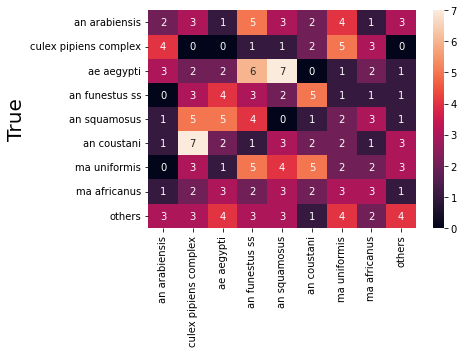

In [47]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [48]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

[array([0.97267484, 0.28935342, 0.12624243, 0.27429693, 0.6581074 ,
       0.7064505 , 0.44883687, 0.67008191, 0.02614779]), array([0.11419134, 0.54262519, 0.07897874, 0.25543415, 0.6272882 ,
       0.29948068, 0.54789235, 0.24662933, 0.24079592]), array([0.92894339, 0.9985831 , 0.34295308, 0.5258334 , 0.01838288,
       0.51264442, 0.64972687, 0.6901066 , 0.24121922]), array([0.66670934, 0.39710742, 0.2992735 , 0.5851808 , 0.95406002,
       0.39311301, 0.69503672, 0.70810513, 0.05558973]), array([0.97041423, 0.24541849, 0.96504851, 0.09473856, 0.75133549,
       0.73874313, 0.96919686, 0.52822991, 0.22215417]), array([0.64178038, 0.30202302, 0.03369166, 0.11238461, 0.76986673,
       0.63807604, 0.16468058, 0.77620943, 0.62923022]), array([0.78372433, 0.02175306, 0.00283159, 0.92443779, 0.75545024,
       0.12712017, 0.64894125, 0.39599496, 0.66529346]), array([0.06961813, 0.63365416, 0.8471646 , 0.34307241, 0.49661739,
       0.56446823, 0.06322111, 0.5723355 , 0.69282578]), array([

ValueError: continuous-multioutput is not supported

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))